# MNIST Fashion classification with convolutional neural network

Study the Convolutionnal neural network (CNN) tutorial of Keras on the classification of the MNIST Fashion Dataset

Learning goals:
- Understand the model structure
- Evaluate and enhance the model
- Use several kinds of regularizers to improve the generalization (kernel/bias, dropout, dataset augmentation)

To compare with the [Dense (Perceptron) only implementation](../classification/ClassificationMultiMnistFashion.html) ([Notebook](../classification/ClassificationMultiMnistFashion.ipynb))

References:
1. [Introduction to CNNs - Tensorflow/Keras](https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns)
2. [Keras Conv2D and Convolutional layer - PyImageSearch](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(keras.__version__)

# Patch for macOS + Conda
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2.2.4-tf


## Data

Using the fashion MNIST dataset from https://github.com/zalandoresearch/fashion-mnist
It is made of 70k pictures classified in 10 categories. 
Images are greyscale, 28x28 pixels.

The train/test split is 60/10

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_width = 28
image_height = 28
image_nchannels = 1
n_classes = len(class_names)

In [4]:
train_images.shape

(60000, 28, 28)

Reshaping to get a tensor with the channels, and scaling the 8 bit pixels of the images to float values in [0,1)

In [6]:
train_images = train_images.reshape(60000, image_width, image_height, image_nchannels) / 255.0
test_images = test_images.reshape(10000, image_width, image_height, image_nchannels) / 255.0

## Helpers

In [8]:
def plot_history(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'])
    if with_validation:
        plt.plot(hist.history['val_loss'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Loss')
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'])
    if with_validation:
        plt.plot(hist.history['val_acc'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Accuracy');

# 2D Convolutional neural network (CNN)

https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns  __!! Tensorflow v2.0-beta tutorial__ but it works with TF v1.14, convergence is slower though

In [7]:
model5 = keras.models.Sequential([
    # Single image channel
    keras.layers.Conv2D(32, (3, 3), activation=keras.activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
], 'model5')

model5.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model5.summary()

hist5 = model5.fit(train_images, train_labels, 
                   epochs=25, validation_split=0.2, 
                   verbose=0)

W0819 09:32:44.010488 4489266624 deprecation.py:506] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928

Final train accuracy: 0.979


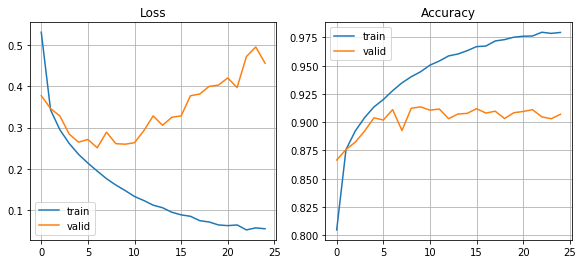

In [9]:
plot_history(hist5, True)
print('Final train accuracy: {:.3f}'.format(hist5.history['acc'][-1]))

In [10]:
test_loss5, test_acc5 = model5.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f} accuracy: {:.3f}'.format(test_loss5, test_acc5))

Test loss: 0.514 accuracy: 0.903


Here again there is a difference between the training and validation or test accuracies.

The result is quite lower compared to the referenced tutorial (claiming 99% test accuracy). Is this due to the use of Tensorflow 1.14 vs. 2.0-beta ?

As on the classical model, there is probably overfitting.

Here is the histogram of the ceofficients of the Dense layer of 64 neurons:

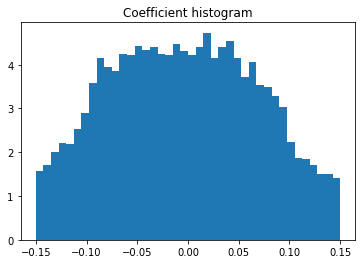

In [12]:
plt.hist(model5.get_weights()[6].reshape(-1), bins=40, range=(-0.15, 0.15), density=True);
plt.title('Coefficient histogram');

## CNN with regularizer

Let's apply a regularizer on the two largest layers, and decrease the size of the last Conv2D and the 1st Dense layers from 64 to 48.

In [13]:
model6 = keras.models.Sequential([
    # Single image channel
    keras.layers.Conv2D(32, (3, 3), activation=keras.activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(48, (3, 3), activation=keras.activations.relu,
                        bias_regularizer=keras.regularizers.l1(0.00001),   # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Flatten(),
    keras.layers.Dense(48, activation=keras.activations.relu,             # <---
                       bias_regularizer=keras.regularizers.l1(0.00001),    # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Dense(10, activation=keras.activations.softmax)
], 'model6')

model6.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model6.summary()

hist6 = model6.fit(train_images, train_labels, 
                   epochs=24, validation_split=0.2, 
                   verbose=0)

Model: "model6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 48)          27696     
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                20784

Final train accuracy: 0.973


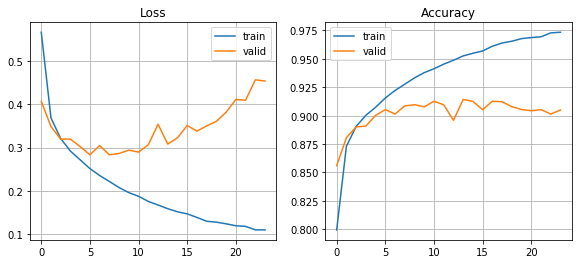

In [14]:
plot_history(hist6, True)
print('Final train accuracy: {:.3f}'.format(hist6.history['acc'][-1]))

In [16]:
test_loss6, test_acc6 = model6.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f} accuracy: {:.3f}'.format(test_loss6, test_acc6))

Test loss: 0.470 accuracy: 0.898


Train accuracy is a little lower, test accuracy is the same as with the bigger model.

Coefficients are better spread on the layers with regularizers

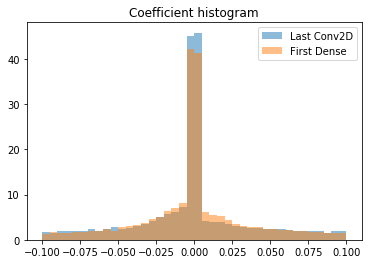

In [15]:
weights6 = model6.get_weights()
plt.hist(weights6[4].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.5);
plt.hist(weights6[6].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.5);
plt.legend(('Last Conv2D', 'First Dense'))
plt.title('Coefficient histogram');